In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2  
import os
from scipy.signal import wiener as scipy_wiener

## Step 0: Reading Dataset

In [2]:
df = pd.read_csv('./dataset/image_label.csv')
display(df.head())  
df['Plane'].unique()

,Image_name,Plane
0,Patient01018_Plane3_2_of_3,Fetal brain
1,Patient00770_Plane3_2_of_3,Fetal brain
2,Patient00853_Plane3_1_of_3,Fetal brain
3,Patient01230_Plane3_5_of_5,Fetal brain
4,Patient01494_Plane3_3_of_4,Fetal brain


array(['Fetal brain', 'Fetal femur', 'Fetal thorax', 'Fetal abdomen'],
      dtype=object)

### Filtering the Dataset According to Categories

In [3]:
femur = df[df['Plane']=='Fetal femur'].iloc[16:]
brain = df[df['Plane']=='Fetal brain']
thorax = df[df['Plane']=='Fetal thorax']
abdomen = df[df['Plane']=='Fetal abdomen']

In [4]:
def display_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Image Selection

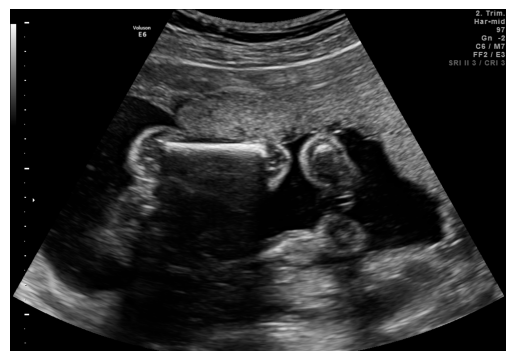

In [5]:
row = femur.iloc[14]
name = row['Image_name']
path = os.path.join('./dataset/images', name + '.png')
img = cv2.imread(path)
display_image(img)

## Step 1: Preprocessing Image

### Resizing image to 512×512 size to maintain uniformity across all images of different dimensions

In [6]:
def resizeImage(img):

    target_size = (512, 512)
    old_size = img.shape[:2]
    ratio = min(target_size[0] / old_size[0], target_size[1] / old_size[1])
    new_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))
    img_resized = cv2.resize(img, new_size)

    # Padding the resized image to the target size
    delta_w = target_size[1] - new_size[0]
    delta_h = target_size[0] - new_size[1]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    
    return img_padded

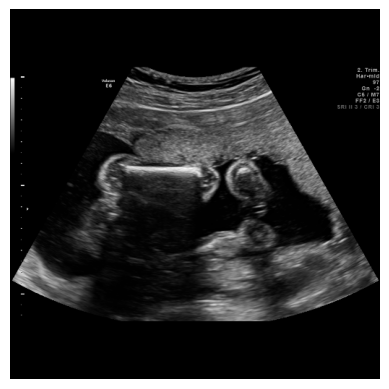

In [7]:
resized = resizeImage(img)
display_image(resized)

### Noise adaptive fuzzy switching median filter (NAFSM)

In [8]:
def nafsm_filter(image, threshold=25):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    img_filtered = image.copy()
    rows, cols = img_filtered.shape
    window_size = 3
    
    # Traverse the image
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            window = img_filtered[i-1:i+2, j-1:j+2].flatten()
            median_val = np.median(window)
            if abs(img_filtered[i, j] - median_val) > threshold:
                img_filtered[i, j] = median_val
    
    return img_filtered

### Speckle reduction anisotropic reduction filter (SRAD)

In [9]:
def srad_filter(image, iterations=10, kappa=30, gamma=0.1):
    img = image.astype('float32')
    for _ in range(iterations):
        # gradients
        delta_north = np.roll(img, -1, axis=0) - img
        delta_south = np.roll(img, 1, axis=0) - img
        delta_east = np.roll(img, -1, axis=1) - img
        delta_west = np.roll(img, 1, axis=1) - img

        # diffusion coefficients based on gradients
        c_north = np.exp(-(delta_north/kappa)**2)
        c_south = np.exp(-(delta_south/kappa)**2)
        c_east = np.exp(-(delta_east/kappa)**2)
        c_west = np.exp(-(delta_west/kappa)**2)

        # apply diffusion
        img += gamma * (c_north * delta_north + c_south * delta_south +
                        c_east * delta_east + c_west * delta_west)
    return np.clip(img, 0, 255).astype('uint8')

### Median filter

In [10]:
def median_filter(image, kernel_size=3):
    return cv2.medianBlur(image, kernel_size)

### Wiener filter

In [11]:
def wiener_filter(image, kernel_size=7):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    filtered_image = scipy_wiener(image, (kernel_size, kernel_size))
    
    filtered_image = np.uint8(np.clip(filtered_image, 0, 255))
    
    return filtered_image

### Adaptive median filter

In [12]:
def adaptive_median_filter(image, kernel_size=3, max_kernel_size=7):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    rows, cols = image.shape

    padded_image = np.pad(image, ((max_kernel_size // 2, max_kernel_size // 2), 
                                  (max_kernel_size // 2, max_kernel_size // 2)), 
                          mode='constant', constant_values=0)

    img_filtered = np.copy(image)

    for i in range(rows):
        for j in range(cols):
            kernel_size = 3 
            while kernel_size <= max_kernel_size:
                half_size = kernel_size // 2
                window = padded_image[i:i+kernel_size, j:j+kernel_size]

                min_val = np.min(window)
                max_val = np.max(window)
                median_val = np.median(window)

                # adaptive median filter logic
                if min_val < median_val < max_val:
                    img_filtered[i, j] = median_val
                    break
                else:
                    kernel_size += 2

    return img_filtered

### Hybrid Filter NAFSM + SRAD

In [13]:
def hybrid_filter_p1(image):
    # NAFSM
    image = nafsm_filter(image)
    # SRAD
    image = srad_filter(image)
    return image

### Gaussian Filter

In [15]:
def gaussian_filter(image):
    return cv2.GaussianBlur(image, (7, 7), 0)

### Comparison between all filters

C:\Users\2shas\AppData\Local\Temp\ipykernel_10920\1127923609.py:7: RuntimeWarning: invalid value encountered in cast
  filtered_image = np.uint8(np.clip(filtered_image, 0, 255))


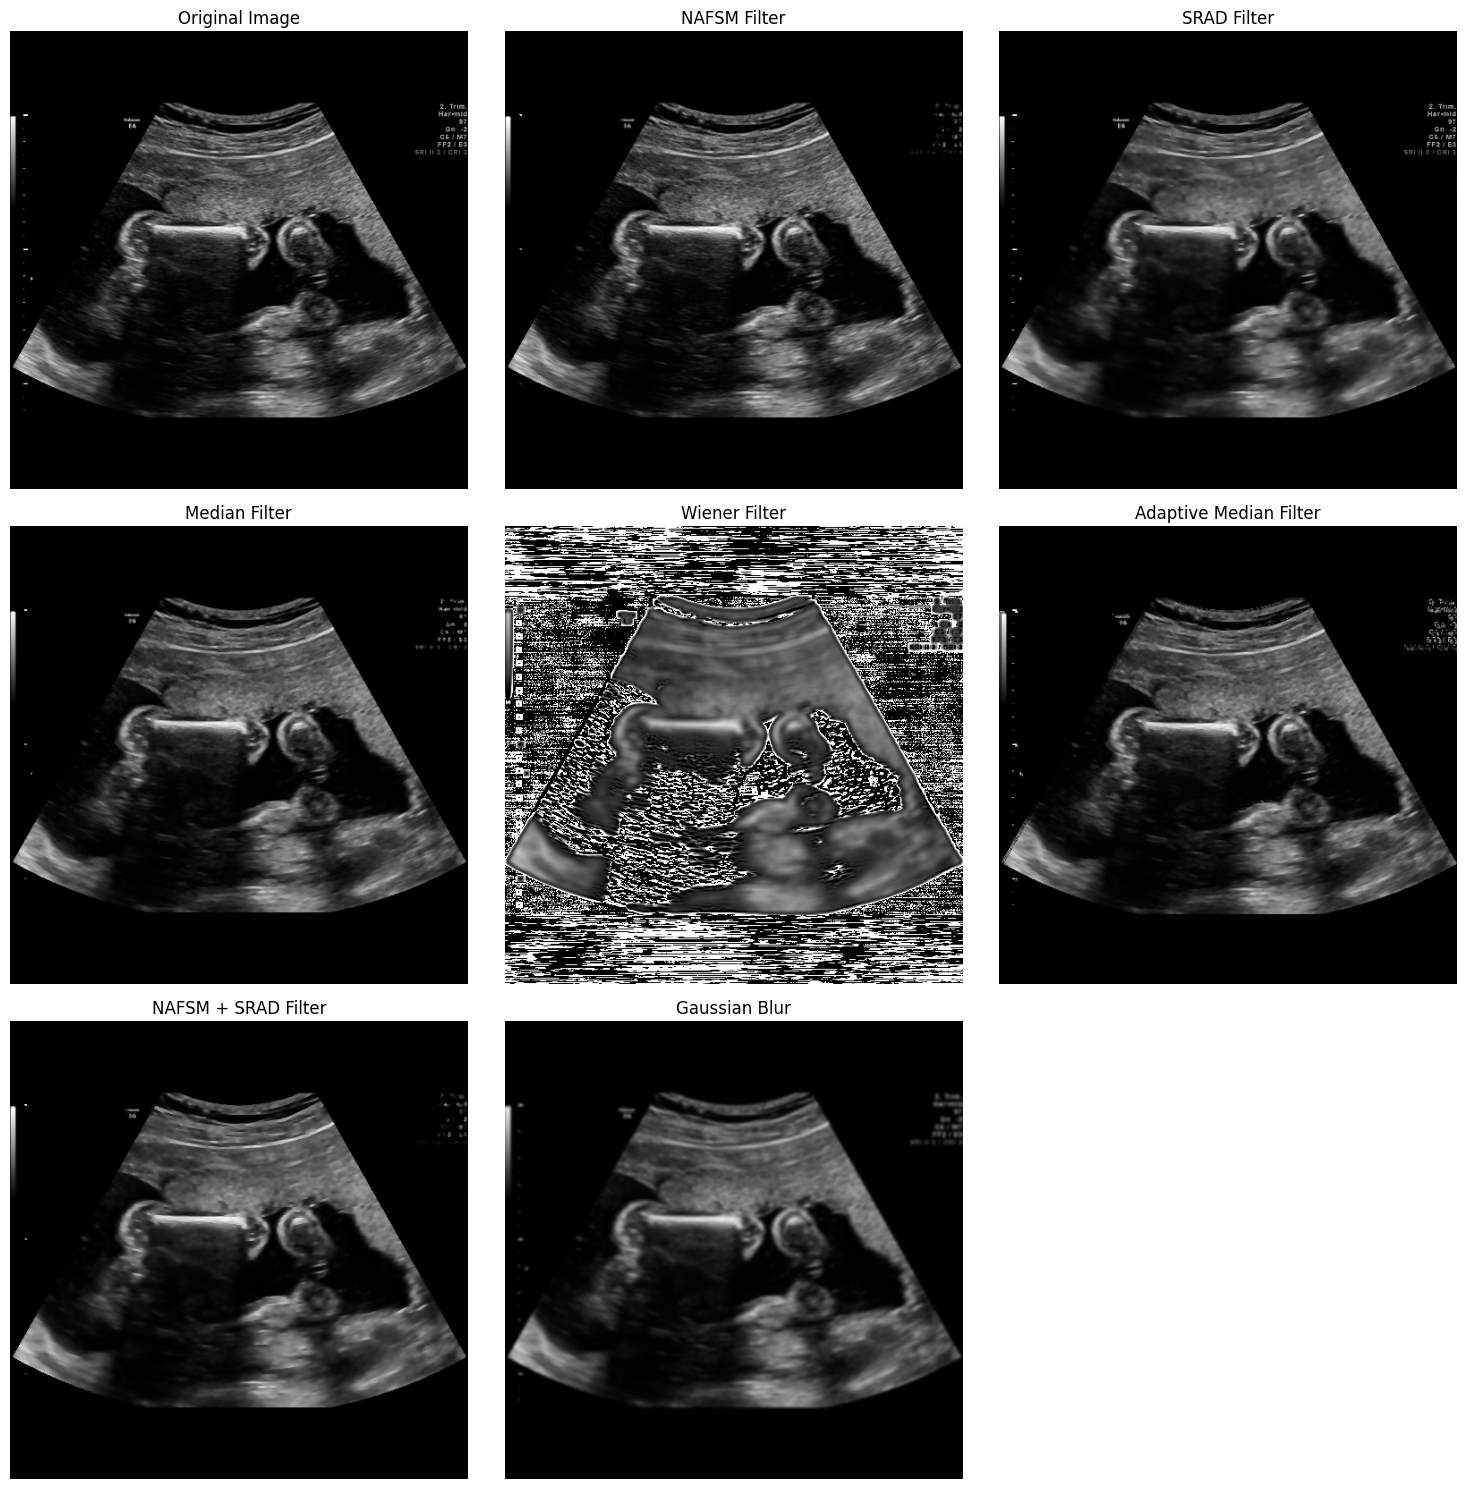

In [16]:
nafsm = nafsm_filter(resized)
srad = srad_filter(resized)
median = median_filter(resized)
wiener = wiener_filter(resized)
adaptive_median = adaptive_median_filter(resized)
nafsm_srad = hybrid_filter_p1(resized)
gaussian = gaussian_filter(resized)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

titles = [
    "Original Image", "NAFSM Filter", "SRAD Filter",
    "Median Filter", "Wiener Filter", "Adaptive Median Filter",
    "NAFSM + SRAD Filter", "Gaussian Blur", "Filtered Comparison"
]

images = [
    resized, nafsm, srad, median, wiener, adaptive_median,
    nafsm_srad, gaussian
]

for i, ax in enumerate(axs.flat):
    if i < len(images):
        ax.imshow(images[i], cmap='gray')
        ax.set_title(titles[i])
        ax.axis('off')

axs[2, 2].axis('off')

plt.tight_layout()
plt.show()  

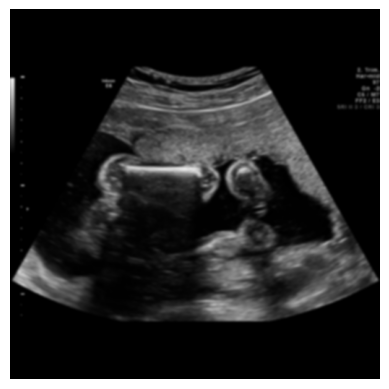

In [17]:
preprocessed = gaussian_filter(resized)
display_image(preprocessed)

## Step 2: Segmentation (Thresholding)

In [18]:
def segment_image(image):
    _, binary_img = cv2.threshold(image, 130, 255, cv2.THRESH_BINARY)
    return binary_img

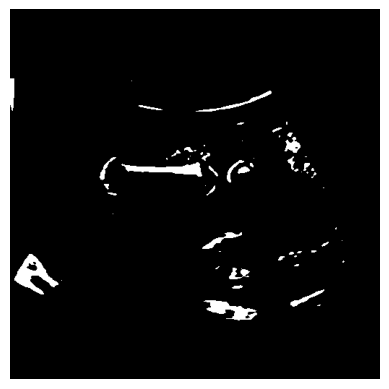

In [19]:
segmented = segment_image(preprocessed)
display_image(segmented)

## Step 3 : Apply Convex Hull on the segmented regions

In [20]:
def apply_convex_hull(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_points = np.zeros_like(image)
    contour_points = cv2.drawContours(contour_points, contours, -1, 255, thickness=cv2.FILLED)
    
    longest_distance = 0
    longest_contour = None
    longest_distance_points = (None, None)
    
    # Looping over each contour to find the one with the longest distance between any two points
    for contour in contours:
        for i in range(len(contour)):
            for j in range(i + 1, len(contour)):
                # Euclidean distance between two points in the contour
                dist = cv2.norm(contour[i][0] - contour[j][0])
                if dist > longest_distance:
                    longest_distance = dist
                    longest_contour = contour
                    longest_distance_points = (tuple(contour[i][0]), tuple(contour[j][0]))
    
    convex_hull_img = np.zeros_like(image)
    
    if longest_contour is not None:
        hull = cv2.convexHull(longest_contour)
        cv2.drawContours(convex_hull_img, [hull], -1, 255, thickness=cv2.FILLED)
    
    return contour_points, convex_hull_img

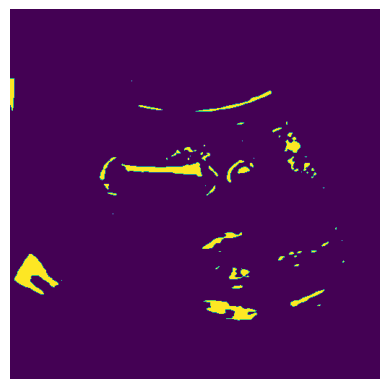

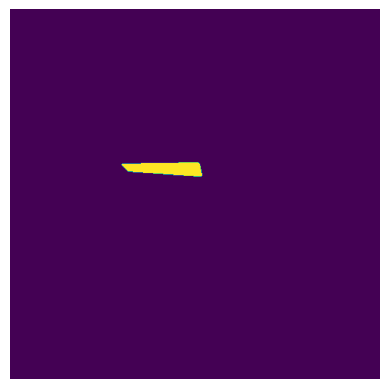

In [21]:
contours, convexHull = apply_convex_hull(segmented)
display_image(contours)
display_image(convexHull)

## Step 4: Extract Femur Length and Draw Markings

In [22]:
def extract_femur_length(image, original_image):
    marked_image = original_image.copy()
    
    # Extract contours from the convex hull image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_farthest_dist = 0
    point1, point2 = None, None
    
    for contour in contours:
        for i in range(len(contour)):
            for j in range(i + 1, len(contour)):
                dist = cv2.norm(contour[i][0] - contour[j][0])
                if dist > max_farthest_dist:
                    max_farthest_dist = dist
                    point1, point2 = tuple(contour[i][0]), tuple(contour[j][0])

    if point1 and point2:
        cv2.circle(marked_image, point1, 8, (0, 255, 0), -1)
        cv2.circle(marked_image, point2, 8, (0, 0, 255), -1)
        cv2.line(marked_image, point1, point2, (255, 0, 0), 3)
    
    marked_image = cv2.cvtColor(marked_image, cv2.COLOR_BGR2RGB)
    return max_farthest_dist, point1, point2, marked_image

Femur length: 112.01 pixels
Farthest points: (154, 215), (265, 230)


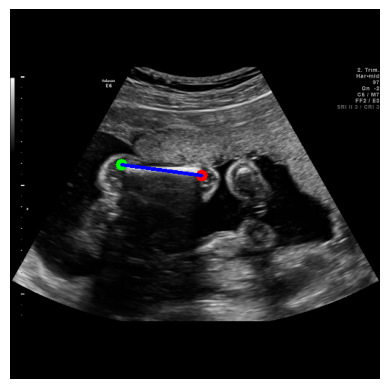

In [23]:
femur_length, point1, point2, marked_image = extract_femur_length(convexHull, resized)

print(f"Femur length: {femur_length:.2f} pixels")
print(f"Farthest points: {point1}, {point2}")
display_image(marked_image)

## Conversion of Pixel Length of Femur to Fetus Height

### Converting Pixel Length of Femur to mm:
DPI = 96 for these given set of images <br>
FemurLength (in mm) = ((PixelLengthofFemur) / (DPI))*25.4

### Approximating Fetus Height with Femur Length:
FetusHeight (in cm) = 6.18 + 0.59 * (FemurLength)

In [24]:
# cv2.imwrite('femur.png', marked_image)

In [25]:
def fetus_height(femur_length):
    image_dpi = 96
    femur_length_in_mm = ((femur_length/image_dpi)*25.4)
    fetus_height = 6.18 + 0.59*femur_length_in_mm
    return fetus_height, femur_length_in_mm

In [26]:
height, femur_length_mm = fetus_height(femur_length)
print(f"Femur length in mm: {femur_length_mm:.2f} mm")
print(f"Fetus height: {height:.2f} cm")

Femur length in mm: 29.64 mm
Fetus height: 23.67 cm


### Approximation of Gestational Age

In [27]:
def cal_gest(femur_length):
    ga= 0.262**(2)*(femur_length/10) + 2*(femur_length/10)+11.5
    return ga


In [28]:
print(f"Gestational Age: {cal_gest(femur_length_mm):.2f} weeks")

Gestational Age: 17.63 weeks


In [ ]:
# image_dir = './dataset/images'

# def load_images(directory):
#     images = []
#     for filename in femur['Image_name']:
#         img_path = os.path.join(directory, filename+'.png')
#         image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#         if image is not None:
#             images.append(image)
#     return images

In [ ]:
# images = load_images(image_dir)

# path = './results'
# i = 0
# for img in images:
#     resized = resizeImage(img)
#     preprocessed_img = preprocess_image(resized)
#     segmented_img = segment_image(preprocessed_img)
#     contours, convexHull = apply_convex_hull(segmented_img)
#     femur_length, point1, point2, marked_image = extract_femur_length(convexHull, resized)
#     name = femur.iloc[i]['Image_name']
#     cv2.imwrite(os.path.join(path, name+'.png'), marked_image)
#     i+=1